In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pc  # custom module

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Path to dataset
data_folder = "/app/data"
# Training parameters
EP = 20
BS = 32
# Image resolution
RES = (224, 224)
# Random seed
SEED = 42

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

CUDA enabled.


In [2]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed=SEED,
)

In [3]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]
label_encoder = data_dict["label_encoder"]

print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 5329
Number of validation samples: 665
Number of test samples: 665


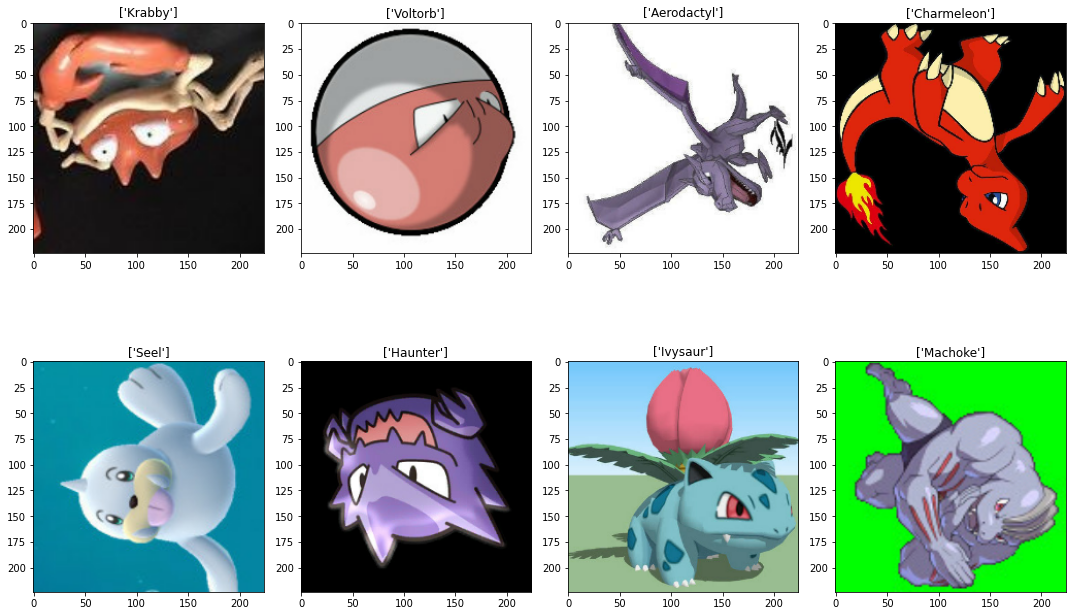

In [4]:
plt.figure(figsize=(15, 10))

# Iterate over batches
for (image_batch, label_batch) in train_dataset:
    # Iterate over elements in batch
    for i, (image, label) in enumerate(zip(image_batch[:8], label_batch[:8])):
        plt.subplot(2, 4, i + 1)
        plt.title(label_encoder.inverse_transform([label]))
        plt.imshow((255 * image.numpy()).astype(np.uint8))
    break

plt.tight_layout()
plt.show()

Training: done
Validation: done
Test: done


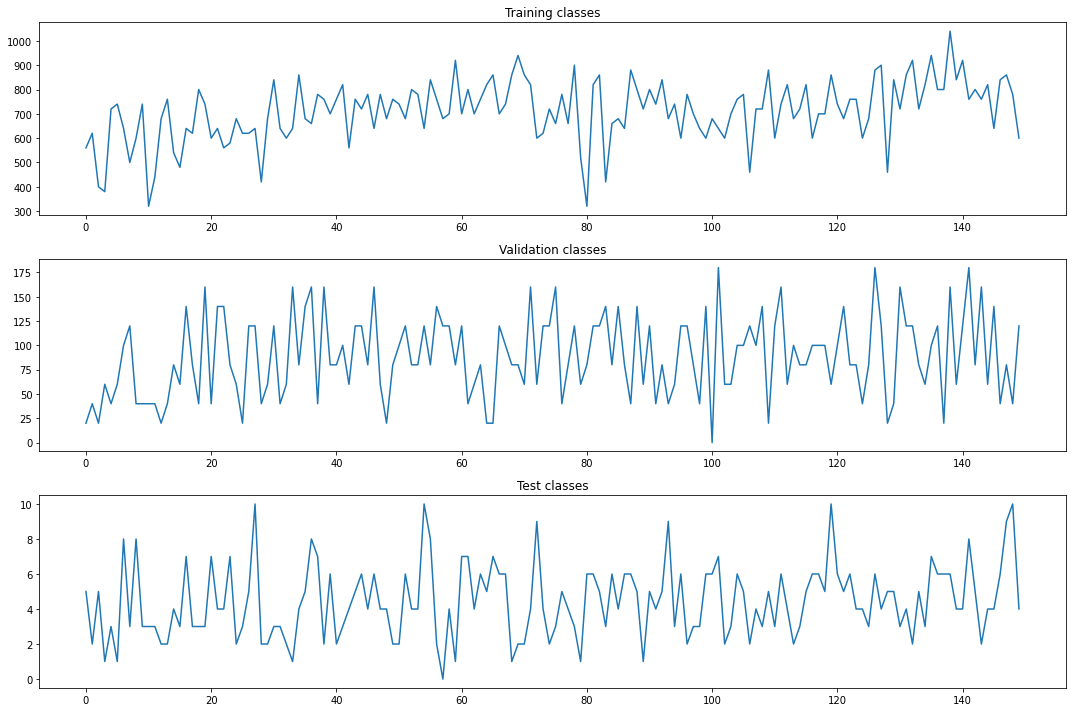

In [5]:
train_labels = []
for i, (_, label_batch) in enumerate(train_dataset):
    for label in label_batch:
        train_labels.append(label.numpy())
print("Training: done")
        
val_labels = []
for i, (_, label_batch) in enumerate(val_dataset):
    for label in label_batch:
        val_labels.append(label.numpy())
print("Validation: done")

test_labels = []
for i, (_, label) in enumerate(test_dataset):
    test_labels.append(label.numpy())
    print(f"{i + 1}/{test_len}", end="\r", flush=True)
print("Test: done")

train_bincount = np.bincount(train_labels)
val_bincount = np.bincount(val_labels)
test_bincount = np.bincount(test_labels)

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(train_bincount)
plt.title("Training classes")
plt.subplot(3, 1, 2)
plt.plot(val_bincount)
plt.title("Validation classes")
plt.subplot(3, 1, 3)
plt.plot(test_bincount)
plt.title("Test classes")
plt.tight_layout()
plt.show()

In [ ]:
model = pc.create_model(n_conv=5, use_bn=False, res=RES)
model.summary()

In [6]:
model = tf.keras.applications.MobileNetV2(
    input_shape=(*RES, 3),
    weights=None,
    classes=150
)
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [7]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=EP,
    steps_per_epoch=train_len // BS,
    validation_data=val_dataset,
    validation_steps=val_len // BS
)

Epoch 1/20
166/166 [==============================] - 61s 317ms/step - loss: 4.8771 - accuracy: 0.0209 - val_loss: 5.0454 - val_accuracy: 0.0047
Epoch 2/20
166/166 [==============================] - 184s 1s/step - loss: 4.0004 - accuracy: 0.0646 - val_loss: 5.3490 - val_accuracy: 0.0109
Epoch 3/20
166/166 [==============================] - 194s 1s/step - loss: 3.5090 - accuracy: 0.1235 - val_loss: 5.8392 - val_accuracy: 0.0094
Epoch 4/20
166/166 [==============================] - 194s 1s/step - loss: 3.1866 - accuracy: 0.1767 - val_loss: 6.6146 - val_accuracy: 0.0094
Epoch 5/20
 56/166 [=========>....................] - ETA: 2:03 - loss: 3.0841 - accuracy: 0.1998

KeyboardInterrupt: 

In [ ]:
# Save model (tensorflow standard format)
model.save("model1")